In [1]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import euclidean
from scipy.stats import entropy
from scipy.signal import savgol_filter, spectrogram
from scipy.fft import fft
import pywt

In [2]:
# Load .mat files
def load_mat_files(file_paths):
    data = {}
    for key, path in file_paths.items():
        mat_data = scipy.io.loadmat(path)
        for k, v in mat_data.items():
            if not k.startswith("__"):
                data[key] = v.flatten()
    return pd.DataFrame(data)

In [3]:
# Preprocessing: Min-Max Normalization and Savitzky-Golay Filtering
def preprocess_data(df):
    df_normalized = (df - df.min()) / (df.max() - df.min())
    df_denoised = df_normalized.apply(lambda x: savgol_filter(x, window_length=61, polyorder=3))
    print("Step 1: Preprocessing Data")
    print(df_denoised.head())
    return df_denoised

df = load_mat_files({
    "APPLIANCES": "APPLIANCES.mat",
    "HVAC": "HVAC.mat",
    "LIGHTING": "LIGHTING.mat",
    "MAINS": "MAINS.mat",
    "OTHER_LOADS": "OTHER_LOADS.mat"
})

df_denoised = preprocess_data(df)
print("Preprocessing complete. Denoised data displayed above.\n")

Step 1: Preprocessing Data
   APPLIANCES      HVAC  LIGHTING     MAINS  OTHER_LOADS
0    0.109307  0.044310  0.186247  0.099183     0.348328
1    0.107912  0.044401  0.180529  0.097740     0.344494
2    0.106527  0.044492  0.174908  0.096323     0.340744
3    0.105151  0.044582  0.169386  0.094932     0.337080
4    0.103785  0.044672  0.163962  0.093567     0.333500
Preprocessing complete. Denoised data displayed above.



Step 2: Computing Euclidean Distances


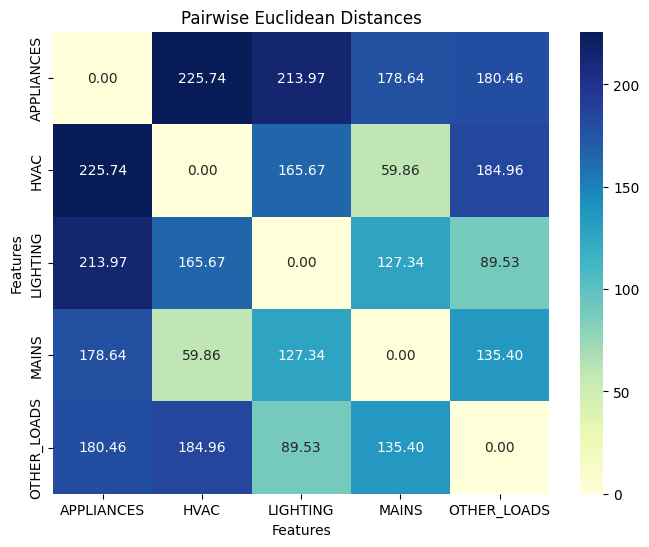

Euclidean distance matrix displayed above.



In [4]:
# Compute Euclidean Distances and Plot Heatmap
def compute_euclidean_distances(df):
    print("Step 2: Computing Euclidean Distances")
    features = df.columns
    num_features = len(features)
    distance_matrix = np.zeros((num_features, num_features))
    for i, f1 in enumerate(features):
        for j, f2 in enumerate(features):
            distance_matrix[i, j] = euclidean(df[f1], df[f2])
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(distance_matrix, annot=True, fmt=".2f", cmap="YlGnBu",
                xticklabels=features, yticklabels=features)
    plt.xlabel("Features")
    plt.ylabel("Features")
    plt.title("Pairwise Euclidean Distances")
    plt.show()
    return distance_matrix

euclidean_distances = compute_euclidean_distances(df_denoised)
print("Euclidean distance matrix displayed above.\n")

Step 3: Computing FFT Distances


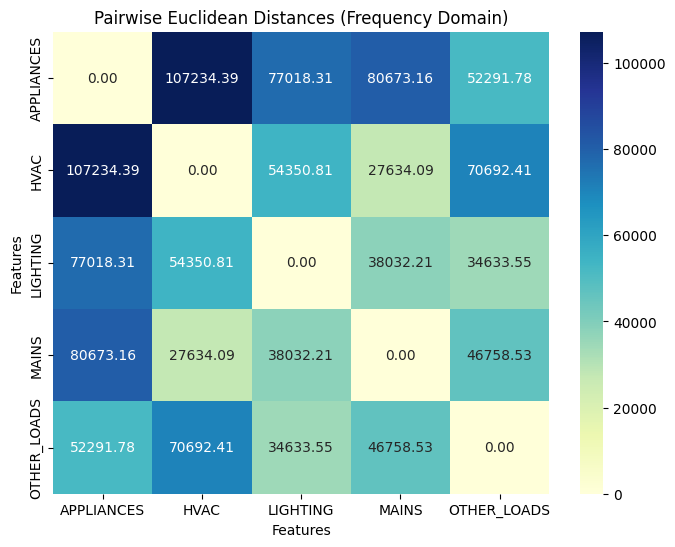

FFT distance matrix displayed above.



In [5]:
# Compute FFT and Euclidean Distances in Frequency Domain
def compute_fft_distances(df):
    print("Step 3: Computing FFT Distances")
    fft_df = df.apply(lambda x: np.abs(fft(x)))
    features = df.columns
    num_features = len(features)
    fft_distance_matrix = np.zeros((num_features, num_features))
    for i, f1 in enumerate(features):
        for j, f2 in enumerate(features):
            fft_distance_matrix[i, j] = euclidean(fft_df[f1], fft_df[f2])
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(fft_distance_matrix, annot=True, fmt=".2f", cmap="YlGnBu",
                xticklabels=features, yticklabels=features)
    plt.xlabel("Features")
    plt.ylabel("Features")
    plt.title("Pairwise Euclidean Distances (Frequency Domain)")
    plt.show()
    return fft_distance_matrix

fft_distances = compute_fft_distances(df_denoised)
print("FFT distance matrix displayed above.\n")

Step 4: Computing KL Divergence


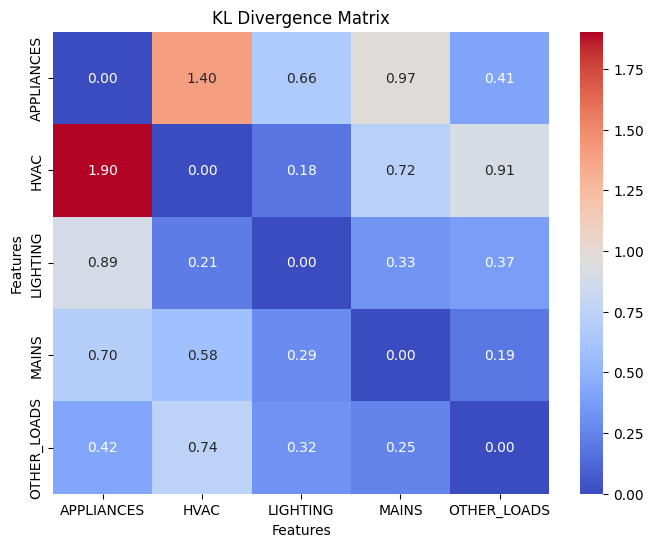

KL Divergence matrix displayed above.



In [6]:
# Compute KL Divergence
def compute_kl_divergence(df):
    print("Step 4: Computing KL Divergence")
    num_bins = 50
    histograms = {feature: np.histogram(df[feature], bins=num_bins, density=True)[0] for feature in df.columns}
    num_features = len(df.columns)
    kl_matrix = np.zeros((num_features, num_features))
    
    for i, f1 in enumerate(df.columns):
        for j, f2 in enumerate(df.columns):
            if i != j:
                kl_matrix[i, j] = entropy(histograms[f1], histograms[f2])
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(kl_matrix, annot=True, fmt=".2f", cmap="coolwarm",
                xticklabels=df.columns, yticklabels=df.columns)
    plt.xlabel("Features")
    plt.ylabel("Features")
    plt.title("KL Divergence Matrix")
    plt.show()
    return kl_matrix

kl_divergence_matrix = compute_kl_divergence(df_denoised)
print("KL Divergence matrix displayed above.\n")

In [7]:
# Perform Wavelet Transform
def compute_wavelet_features(df):
    print("Step 5: Performing Wavelet Transform")
    energy_comparison = {}
    for feature in df.columns:
        coeffs = pywt.wavedec(df[feature], wavelet='db1', level=4)
        energy = [np.sum(np.square(c)) for c in coeffs]
        energy_comparison[feature] = energy
    
    energy_df = pd.DataFrame(energy_comparison, index=[f'Level {i}' for i in range(len(energy_comparison[feature]))])
    print("\nEnergy Comparison Across Features:")
    print(energy_df)
    return energy_df

wavelet_features = compute_wavelet_features(df_denoised)
print("Wavelet energy features displayed above.\n")

Step 5: Performing Wavelet Transform

Energy Comparison Across Features:
           APPLIANCES          HVAC      LIGHTING         MAINS   OTHER_LOADS
Level 0  73806.114543  10502.302956  26268.166101  17436.754106  41435.838329
Level 1     51.003588      6.555417     65.695615     11.507592     51.826112
Level 2     12.845319      1.648099     16.542243      2.894338     13.053640
Level 3      3.217293      0.412622      4.142952      0.724692      3.269514
Level 4      0.804718      0.103195      1.036211      0.181245      0.817768
Wavelet energy features displayed above.



Step 6: Performing Spectrogram Analysis


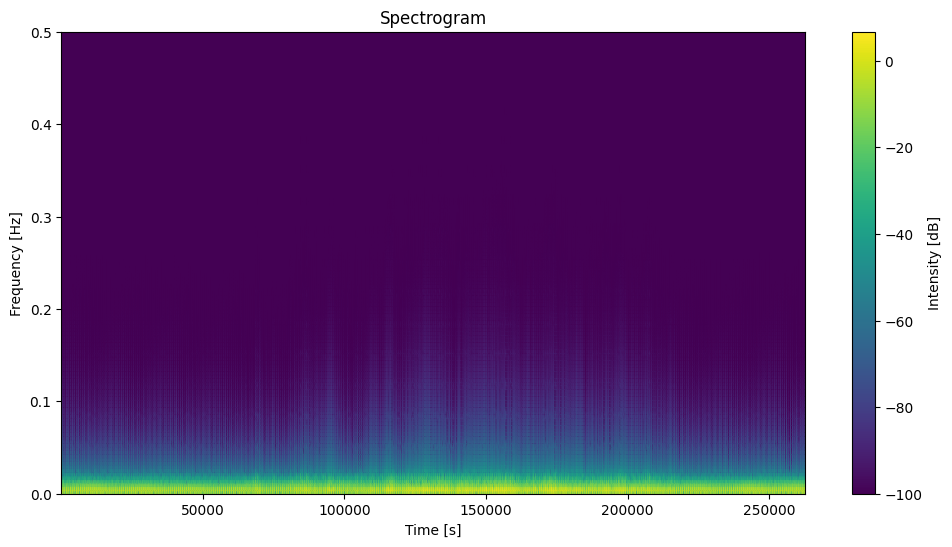

Spectrogram analysis completed and displayed above.



In [8]:

# Spectrogram Analysis
def plot_spectrogram_analysis(series, title="Spectrogram"):
    print("Step 6: Performing Spectrogram Analysis")
    f, t, Sxx = spectrogram(series, fs=1, nperseg=256, noverlap=128, window='hann')
    plt.figure(figsize=(12, 6))
    plt.pcolormesh(t, f, 10 * np.log10(Sxx + 1e-10), shading='gouraud', cmap='viridis')
    plt.colorbar(label='Intensity [dB]')
    plt.xlabel('Time [s]')
    plt.ylabel('Frequency [Hz]')
    plt.title(title)
    plt.show()

plot_spectrogram_analysis(df_denoised['MAINS'])
print("Spectrogram analysis completed and displayed above.\n")